Tables created: Employess and Departments

Rolap Result (SQL aggregation):
    department    age_salary
0  Enginnering  61000.000000
1           HR  58333.333333
2        Sales  65000.000000


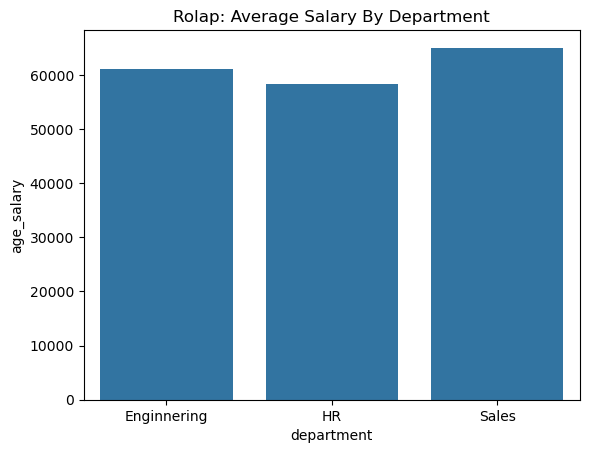

C:\Users\sammi\AppData\Local\Temp\ipykernel_20788\3010027516.py:66: FutureWarning: The provided callable <function mean at 0x00000166591C5A80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  molap_cube=pd.pivot_table(



Molap: Average Salary Cube (Department Vs Age):
age               28       30       32       35       40       45
dept_name                                                        
Enginnering      0.0      0.0  62000.0  60000.0      0.0      0.0
HR               0.0  50000.0      0.0      0.0  55000.0  70000.0
Sales        65000.0      0.0      0.0      0.0      0.0      0.0


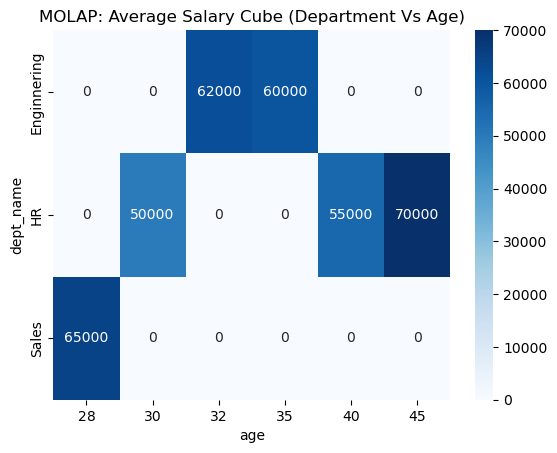


Slice: Engineering Department Employees
   emp_id name  age  dept_id  salary    dept_name
1       2  Bob   35        2   60000  Enginnering
4       5  Eva   32        2   62000  Enginnering

Dice: HR and Sales Employees with Age > 30
   emp_id     name  age  dept_id  salary dept_name
2       3  Charlie   40        1   55000        HR
5       6    Frank   45        1   70000        HR

Drill-down: Salary Details by Department and Employee
     dept_name     name  salary
4  Enginnering      Eva   62000
1  Enginnering      Bob   60000
5           HR    Frank   70000
2           HR  Charlie   55000
0           HR    Alice   50000
3        Sales    David   65000

Roll-up: Total Salary by Department
     dept_name  salary
0  Enginnering  122000
1           HR  175000
2        Sales   65000


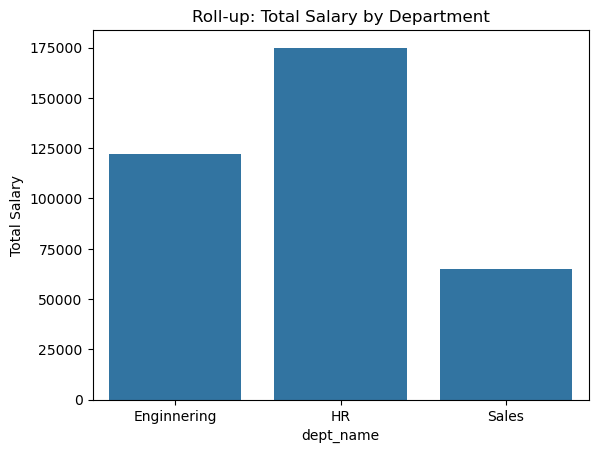


Database connection closed.


In [4]:
# ROLAP Demo
# THis script demonstrates basic OLP operartions 


import pandas as pd 
import numpy as np 
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


#Database Connection
def create_connection(db_file="olap_demo.db"):
    conn= sqlite3.connect(db_file)
    return conn

#Create Sample Data
employees = pd.DataFrame({
    'emp_id':[1, 2, 3, 4, 5, 6],
    'name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva', 'Frank'],
    'age': [30, 35, 40, 28, 32, 45],
    'dept_id': [1, 2, 1, 3, 2, 1],
    'salary': [50000, 60000, 55000, 65000, 62000, 70000]
})

departments= pd.DataFrame({
    'dept_id': [1, 2, 3],
    'dept_name': ['HR', 'Enginnering', 'Sales']
})


#Load Data Into Sqlite database

conn=create_connection()
employees.to_sql('employees', conn, if_exists='replace', index=False)
departments.to_sql('departments', conn, if_exists='replace', index=False)

print("Tables created: Employess and Departments")


#Perform OLP Operations

#ROLAP

query = """

SELECT d.dept_name as department, AVG(e.salary) as age_salary
FROM employees e 
JOIN departments d ON e.dept_id= d.dept_id
GROUP BY d.dept_name
"""

rolap_result = pd.read_sql_query(query, conn)
print("\nRolap Result (SQL aggregation):")
print(rolap_result)

#Visualization

sns.barplot(data=rolap_result, x='department', y='age_salary')
plt.title("Rolap: Average Salary By Department")
plt.show()


#MOLAP Operations

molap_cube=pd.pivot_table(
    employees.merge(departments, on='dept_id'),
    values='salary',
    index='dept_name',
    columns='age',
    aggfunc=np.mean,
    fill_value=0
)
print("\nMolap: Average Salary Cube (Department Vs Age):")
print(molap_cube)

#Visualization

sns.heatmap(molap_cube, annot=True, fmt=".0f", cmap="Blues")
plt.title("MOLAP: Average Salary Cube (Department Vs Age)")
plt.show()


#Holap 
#Combining ROLAP and MOLAP
# HOLAP Operations: Slice, Dice, Drill-down, Roll-up

# Slice: Select data for a specific department (e.g., Engineering)
slice_result = employees.merge(departments, on='dept_id')
slice_engineering = slice_result[slice_result['dept_name'] == 'Enginnering']
print("\nSlice: Engineering Department Employees")
print(slice_engineering)

# Dice: Select data for specific departments and age ranges
dice_result = slice_result[(slice_result['dept_name'].isin(['HR', 'Sales'])) & (slice_result['age'] > 30)]
print("\nDice: HR and Sales Employees with Age > 30")
print(dice_result)

# Drill-down: Show salary details by department and employee
drilldown_result = slice_result[['dept_name', 'name', 'salary']].sort_values(['dept_name', 'salary'], ascending=[True, False])
print("\nDrill-down: Salary Details by Department and Employee")
print(drilldown_result)

# Roll-up: Aggregate salary by department
rollup_result = slice_result.groupby('dept_name')['salary'].sum().reset_index()
print("\nRoll-up: Total Salary by Department")
print(rollup_result)

# Visualization of Roll-up
sns.barplot(data=rollup_result, x='dept_name', y='salary')
plt.title("Roll-up: Total Salary by Department")
plt.ylabel("Total Salary")
plt.show()

# Close database connection
conn.close()
print("\nDatabase connection closed.")
